In [1]:
%pip install transformers datasets sentencepiece accelerate jieba scikit-learn

You should consider upgrading via the '/Users/danilkladnitsky/.pyenv/versions/3.10.4/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Configuration

In [282]:
HSK1_VOCAB_FILE = "data/hsk1.vocab.txt"
# HSK1_DATASET_FILE = "data/hsk1.dataset.jsonl"
HSK1_DATASET_FILE = "data/hsk1-extended.dataset.json"

HSK3_VOCAB_FILE = "data/hsk3.vocab.txt"
HSK3_DATASET_FILE = "data/hsk3.dataset.jsonl"

HSK2_VOCAB_FILE = "data/hsk2.vocab.txt"
HSK2_DATASET_FILE = "data/hsk2.dataset.jsonl"



# Tokenizators

In [287]:
import os
import json
import jieba
from typing import List
from tokenizers import Tokenizer
from tokenizers.models import WordPiece, BPE
from tokenizers.trainers import WordPieceTrainer, BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import NFKC
from transformers import PreTrainedTokenizerFast


def load_vocab(vocab_path: str) -> List[str]:
    with open(vocab_path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f if line.strip()]

def extract_sentences_from_json(dataset_path: str) -> List[str]:
    with open(dataset_path, "r", encoding="utf-8") as f:
        data_list = json.load(f)
        return [
            item["labeled_sentence"]
            for item in data_list
            if "labeled_sentence" in item
        ]

def save_sentences(sentences: List[str], path: str, use_jieba: bool = True):
    with open(path, "w", encoding="utf-8", errors="ignore") as f:
        for sentence in sentences:
            if use_jieba:
                sentence = " ".join(jieba.cut(sentence.strip()))
            # Убираем возможные скрытые символы
            sentence = sentence.replace('\u200b', '').strip()
            f.write(sentence + "\n")

def train_wordpiece_tokenizer(sentences_path: str, tokenizer_dir: str) -> PreTrainedTokenizerFast:
    # Initialize WordPiece model
    tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
    trainer = WordPieceTrainer(
        vocab_size=2000,
        special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
    )

    tokenizer.normalizer = NFKC()
    print(sentences_path)

    # Train from the actual segmented text file
    tokenizer.train([sentences_path], trainer)

    # Save tokenizer JSON and vocab.txt
    tokenizer_path = os.path.join(tokenizer_dir, "tokenizer.json")
    tokenizer.save(tokenizer_path)

    vocab_path = os.path.join(tokenizer_dir, "vocab.txt")
    with open(vocab_path, "w", encoding="utf-8") as f:
        for token, idx in tokenizer.get_vocab().items():
            f.write(token + "\n")

    return PreTrainedTokenizerFast(
        tokenizer_file=tokenizer_path,
        vocab_file=vocab_path,
        unk_token="[UNK]",
        sep_token="[SEP]",
        pad_token="[PAD]",
        cls_token="[CLS]",
        mask_token="[MASK]"
    )

def train_bpe_tokenizer(sentences_path: str, tokenizer_dir: str, vocab: List[str]) -> PreTrainedTokenizerFast:
    model = BPE(unk_token="[UNK]")
    trainer = BpeTrainer(
        vocab_size=30000,
        special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
    )

    tokenizer = Tokenizer(model)
    tokenizer.normalizer = NFKC()
    tokenizer.pre_tokenizer = Whitespace()
    tokenizer.train([sentences_path], trainer)

    tokenizer_path = os.path.join(tokenizer_dir, "tokenizer.json")
    tokenizer.save(tokenizer_path)

    return PreTrainedTokenizerFast(tokenizer_file=tokenizer_path)

def test_tokenizer(tokenizer: PreTrainedTokenizerFast, test_sentences: List[str]):
    for s in test_sentences:
        tokens = tokenizer.tokenize(s)
        ids = tokenizer.encode(s, add_special_tokens=False)
        print(f"\nSentence: {s}")
        print(f"Tokens:   {tokens}")
        print(f"Token IDs: {ids}")

def create_tokenizer(dataset_path: str, vocab_path: str, tokenizer_dir: str, method: str):
    os.makedirs(tokenizer_dir, exist_ok=True)

    # Prepare data
    vocab = load_vocab(vocab_path)
    sentences = extract_sentences_from_json(dataset_path)

    train_txt = os.path.join(tokenizer_dir, "train.txt")
    use_jieba = method in ["wordpiece", "bpe"]
    save_sentences(sentences, train_txt, use_jieba=use_jieba)

    if method == "wordpiece":
        tokenizer = train_wordpiece_tokenizer(train_txt, tokenizer_dir)
    elif method == "bpe":
        tokenizer = train_bpe_tokenizer(train_txt, tokenizer_dir, vocab)
    else:
        raise ValueError(f"Unsupported method: {method}")

    tokenizer.save_pretrained(tokenizer_dir)

    return tokenizer

## Testing tokenizers

In [297]:
import os

def test_all_tokenizers(
    dataset_path: str,
    vocab_path: str,
    base_dir: str = "tokenizers",
    methods: list = ["wordpiece", "bpe"]
):
    for method in methods:
        tokenizer_dir = os.path.join(base_dir, method)
        print(f"\n--- Testing tokenizer: {method} ---")
        tokenizer = create_tokenizer(dataset_path, vocab_path, tokenizer_dir, method)
        test_tokenizer(tokenizer, ["他在学校学习。", "朋友在商店买东西。", "我喜欢跑步。"])


test_all_tokenizers(
        dataset_path=HSK1_DATASET_FILE,
        vocab_path=HSK1_VOCAB_FILE
    )


--- Testing tokenizer: wordpiece ---
tokenizers/wordpiece/train.txt




Sentence: 他在学校学习。
Tokens:   ['他', '##在', '##学校', '##学习', '##。']
Token IDs: [94, 283, 574, 777, 263]

Sentence: 朋友在商店买东西。
Tokens:   ['朋', '##友', '##在', '##商', '##店', '##买', '##东西', '##。']
Token IDs: [179, 312, 283, 450, 470, 371, 610, 263]

Sentence: 我喜欢跑步。
Tokens:   ['[UNK]']
Token IDs: [1]

--- Testing tokenizer: bpe ---




Sentence: 他在学校学习。
Tokens:   ['他', '在', '学校', '学习', '。']
Token IDs: [92, 138, 267, 323, 68]

Sentence: 朋友在商店买东西。
Tokens:   ['朋友', '在', '商店', '买', '东西', '。']
Token IDs: [252, 138, 464, 82, 277, 68]

Sentence: 我喜欢跑步。
Tokens:   ['我', '喜欢', '[UNK]', '[UNK]', '。']
Token IDs: [168, 251, 1, 1, 68]


# Train models

In [292]:
import torch
import os
from datasets import Dataset, load_dataset
from transformers import (GPT2LMHeadModel,
    DataCollatorForLanguageModeling, Trainer, TrainingArguments, BertTokenizer
)
TOKENIZERS_PARALLELISM=False

class ChineseGPTTrainer:
    def __init__(
        self,
        model_name: str,
        dataset_path: str,
        output_dir: str,
        test_size: float = 0.1,
        max_length: int = 64,
        batch_size: int = 4,
        gradient_accumulation_steps: int = 4,
        epochs: int = 3,
        learning_rate: float = 5e-5,
        tokenizer: BertTokenizer = None
    ):
        self.model_name = model_name
        self.dataset_path = dataset_path
        self.output_dir = output_dir
        self.test_size = test_size
        self.max_length = max_length
        self.batch_size = batch_size
        self.gradient_accumulation_steps = gradient_accumulation_steps
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.tokenizer = tokenizer

        # Tokenizer and model
        self.model = GPT2LMHeadModel.from_pretrained(model_name)

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = "[PAD]"
            self.model.config.pad_token_id = self.tokenizer.pad_token_id

        self.train_dataset, self.eval_dataset = self.load_and_tokenize_data()

        self.data_collator = DataCollatorForLanguageModeling(
            tokenizer=self.tokenizer,
            mlm=False,
        )

        self.training_args = TrainingArguments(
            output_dir=self.output_dir,
            overwrite_output_dir=True,
            num_train_epochs=self.epochs,
            per_device_train_batch_size=self.batch_size,
            gradient_accumulation_steps=self.gradient_accumulation_steps,
            learning_rate=self.learning_rate,
            save_steps=500,
            save_total_limit=1,
            eval_steps=100,
            logging_steps=20,
            logging_first_step=True,
            prediction_loss_only=True,
            disable_tqdm=False,
            report_to="none",
            fp16=torch.cuda.is_available(),
            dataloader_num_workers=2,
            push_to_hub=False,
        )

        self.trainer = Trainer(
            model=self.model,
            args=self.training_args,
            train_dataset=self.train_dataset,
            eval_dataset=self.eval_dataset,
            data_collator=self.data_collator,
            tokenizer=self.tokenizer,
        )

    def load_and_tokenize_data(self):
        # Detect file format
        if self.dataset_path.endswith(".jsonl") or self.dataset_path.endswith(".json"):
            dataset = load_dataset("json", data_files=self.dataset_path)["train"]
        else:
            with open(self.dataset_path, encoding="utf-8") as f:
                lines = [line.strip() for line in f if line.strip()]
            dataset = Dataset.from_list([{"text": l} for l in lines])

        # Split dataset
        train_dataset, eval_dataset = dataset.train_test_split(test_size=self.test_size, seed=42).values()

        def tokenize(example):
            # Use labeled_sentence if available
            if "labeled_sentence" in example:
                text = example["labeled_sentence"]
            elif "prompt" in example and "completion" in example:
                text = example["prompt"] + example["completion"]
            elif "text" in example:
                text = example["text"]
            else:
                raise ValueError("Unknown input format.")

            tokenized = self.tokenizer(
                text,
                truncation=True,
                max_length=self.max_length,
                padding="max_length"
            )

            # Set labels for LM: same as input_ids, but pad tokens get -100
            input_ids = tokenized["input_ids"]
            tokenized["labels"] = [
                token_id if token_id != self.tokenizer.pad_token_id else -100
                for token_id in input_ids
            ]

            return tokenized

        return train_dataset.map(tokenize), eval_dataset.map(tokenize)

    def train(self):
        self.trainer.train()

    def save(self):
        self.model.save_pretrained(self.output_dir)
        self.tokenizer.save_pretrained(self.output_dir)


os.environ["TOKENIZERS_PARALLELISM"] = "false"

def train_model(dataset_path, output_dir, tokenizer_dir, method, vocab_path, base_model="ckiplab/gpt2-base-chinese"):
    tokenizer = create_tokenizer(dataset_path=dataset_path, vocab_path=vocab_path, tokenizer_dir=tokenizer_dir, method=method)
    
    trainer = ChineseGPTTrainer(
    model_name=base_model,
    dataset_path=dataset_path,
    output_dir=output_dir,
    tokenizer=tokenizer,
    max_length=64,
    batch_size=4,
    epochs=5,
    learning_rate=5e-5,
    gradient_accumulation_steps=4,
    test_size=0.1,
)

    trainer.train()
    trainer.save()

## Models

In [310]:
# methods = ["bpe", "wordpiece"]
# models = ["ckiplab/gpt2-base-chinese", "uer/gpt2-chinese-cluecorpussmall"]

methods = ["wordpiece"]
models = ["uer/gpt2-chinese-cluecorpussmall"]

for method in methods:
    for model in models:
        train_model(dataset_path=HSK1_DATASET_FILE, vocab_path=HSK1_VOCAB_FILE, output_dir=f"models/extended/hsk1-{method}-{model}", tokenizer_dir=f"tokenizers/hsk1-{method}-{model}-tokenizer", method=method, base_model=model)


tokenizers/hsk1-wordpiece-uer/gpt2-chinese-cluecorpussmall-tokenizer/train.txt





Map: 100%|██████████| 836/836 [00:00<00:00, 4322.27 examples/s]
/var/folders/p9/gl1s91rn2fv_77662_261gb80000gn/T/ipykernel_4096/33508255.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  self.trainer = Trainer(


Step,Training Loss
1,8.901900
20,4.296300
40,2.796600
60,2.467700
80,2.276400
100,2.165100
120,2.161300
140,2.076900
160,1.981600
180,1.960800


# Inference

In [214]:
from transformers import GPT2LMHeadModel, AutoTokenizer
import torch
import re

def remove_prompt(word: str, text: str) -> str:
    prompt = f"请用词语“{word}”造句："
    prompt_length = len(prompt)
    return text[prompt_length:].strip()


def clean_wordpiece_output(text: str) -> str:
    return text.replace("##", "").replace(" ", "")

class ChineseSentenceGenerator:
    def __init__(self, model_path: str, device: str = None):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = GPT2LMHeadModel.from_pretrained(model_path)

        self.model.eval()
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        # Ensure pad token is defined
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            self.model.config.pad_token_id = self.tokenizer.pad_token_id

    def generate(self, word: str, max_length: int = 60, num_return_sequences: int = 1) -> list:
        prompt = f"请用词语“{word}”造句："
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)

        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=max_length,
                do_sample=True,
                top_k=50,
                top_p=0.9,
                temperature=0.8,
                num_return_sequences=num_return_sequences,
                repetition_penalty=1.3,
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )

        print(self.tokenizer.pad_token_id, self.tokenizer.eos_token_id)

        results = []
        for output in outputs:
            decoded = self.tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            sentence = decoded.replace(prompt, "").replace(" ", "").strip()
            sentence = re.split(r"[。！？]", sentence)[0] + "。"  # stop at first punctuation
            results.append(remove_prompt(word, clean_wordpiece_output(sentence)))
            # prompt 请用词语“大”造句:

        return results

def generate_sentences(model_path: str, word: str, max_length: int = 60, num_return_sequences: int = 3):
    generator = ChineseSentenceGenerator(model_path)
    results = generator.generate(word, max_length, num_return_sequences)
    return results

In [303]:
generate_sentences("models/extended/hsk1-bpe-ckiplab/gpt2-base-chinese", "书")

0 None


['你有几本书的电影是对吗?”“我很好,谢谢。', '这本书我昨天买了好几本书。', '你是我的女儿。']

# Benchmark

In [235]:
from typing import List
import jieba

def check_input_word(prompt: str, sentence: str) -> int:
    """
    Проверяет, содержится ли целевое слово из prompt в сгенерированном предложении.
    Предполагается, что слово указано в кавычках внутри prompt, например:
    '请用词语“妈妈”造句：'
    """
    # Извлекаем слово из prompt
    start = prompt.find("“") + 1
    end = prompt.find("”")
    if start > 0 and end > start:
        target_word = prompt[start:end]
        return int(target_word in sentence)
    return 0  # не удалось извлечь слово

def check_hsk_vocab_coverage(vocab_words: List[str], sentence: str) -> float:
    """
    Оценивает долю слов/символов в предложении, которые входят в HSK-лексикон.
    Для оценки используется пословное разбиение и преобразованный словарь, включающий отдельные иероглифы из многословных лексем.
    """
    if not sentence:
        return 0.0

    # Расширим словарь: добавим отдельные символы из многосимвольных слов
    vocab_set = set(vocab_words)
    for word in vocab_words:
        if len(word) > 1:
            for char in list(word):
                vocab_set.add(char)

    sentence_words = jieba.lcut(sentence)
    matched = sum(1 for word in sentence_words if word in vocab_set)
    return matched / len(sentence_words)

def load_hsk_vocab(filepath: str) -> List[str]:
    """
    Загружает HSK-лексемы из текстового файла.
    Каждая строка файла должна содержать одну лексему (иероглиф или слово).
    """
    with open(filepath, "r", encoding="utf-8") as f:
        return [line.strip() for line in f if line.strip()]


hsk_vocab = load_hsk_vocab("data/hsk1.vocab.txt")

# Пример 1: Проверка на наличие слова
print(check_input_word("请用词语“妈妈”造句：", "我喜欢我妈妈"))  # → 1
print(check_input_word("请用词语“爸爸”造句：", "他们找酒店"))  # → 0

# Пример 2: Проверка покрытия HSK-лексикой
print(check_hsk_vocab_coverage(hsk_vocab, "我喜欢我姐姐"))  # → 5/6 = 0.833...
print(check_hsk_vocab_coverage(hsk_vocab, "他找酒店"))     # → 0/5 = 0.0

1
0
0.75
0.3333333333333333


In [313]:
import time
models = [
    "extended/hsk1-bpe-ckiplab/gpt2-base-chinese",
    "extended/hsk1-wordpiece-uer/gpt2-chinese-cluecorpussmall",
]
hsk_vocab = load_hsk_vocab("data/hsk1.vocab.txt")
vocab = hsk_vocab

def create_prompt(word: str):
    return f"请用词语“{word}”造句："

results = dict()
aggregated_results = dict()

def benchmark():
    model_id = 0
    for model in models:
        results[model] = dict()
        total_word_avg = 0
        total_hsk_avg = 0
        num_words = 0

        for word in vocab:
            prompt = create_prompt(word)
            start_time = time.time()
            sentences = generate_sentences(f"models/{model}", word, max_length=60, num_return_sequences=3)
            end_time = time.time()
            inference_time = end_time - start_time
            word_checks = []
            vocab_coverage = []

            for sent in sentences:
                word_check = check_input_word(prompt, sent)
                coverage = check_hsk_vocab_coverage(hsk_vocab, sent)
                word_checks.append(word_check)
                vocab_coverage.append(coverage)


            # at least one sentence should have target word
            word_avg = 0
            if word_checks.count(1) > 0:
                word_avg = 1
            else:
                word_avg = 0

            hsk_avg = sum(vocab_coverage) / len(vocab_coverage)

            results[model][word] = {
                "sentences": sentences,
                "target_word": word_checks,
                "hsk_coverage": vocab_coverage,
                "target_word_avg": word_avg,
                "hsk_coverage_avg": hsk_avg
            }

            total_word_avg += word_avg
            total_hsk_avg += hsk_avg
            num_words += 1

        # Store aggregated results for this model
        aggregated_results[model] = {
            "target_word_avg_total": total_word_avg / num_words,
            "hsk_coverage_avg_total": total_hsk_avg / num_words,
            "model_name": model,
            "inference_time": inference_time
        }
        
        # save model results to json file
        with open(f"benchmarks/extended_dataset/benchmark_{model_id}.json", "w", encoding="utf-8") as f:
            json.dump(results[model], f, ensure_ascii=False)

        # save aggregated results to json file
        with open(f"benchmarks/extended_dataset/benchmark_aggregated_{model_id}.json", "w", encoding="utf-8") as f:
            json.dump(aggregated_results[model], f, ensure_ascii=False)
        model_id += 1


In [314]:
benchmark()

0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None
0 None

In [266]:
import matplotlib.pyplot as plt
import matplotlib
import platform

# Set font to a Chinese-compatible one
if platform.system() == "Windows":
    matplotlib.rcParams['font.family'] = 'Microsoft YaHei'
elif platform.system() == "Darwin":  # macOS
    matplotlib.rcParams['font.family'] = 'Heiti TC'
else:  # Linux (assumes SimHei is installed)
    matplotlib.rcParams['font.family'] = 'SimHei'

# Ensure minus sign is shown properly
matplotlib.rcParams['axes.unicode_minus'] = False

def plot_results(model_name, model_results, top_n=30):
    # Сортировка слов по метрике target_word_avg
    sorted_items = sorted(
        model_results.items(),
        key=lambda item: item[1]["target_word_avg"],
        reverse=True
    )

    # Взять top_n слов
    top_items = sorted_items[:top_n]
    characters = [item[0] for item in top_items]
    word_avgs = [item[1]["target_word_avg"] for item in top_items]
    hsk_avgs = [item[1]["hsk_coverage_avg"] for item in top_items]

    # Plot target_word_avg
    plt.figure(figsize=(12, 6))
    plt.bar(characters, word_avgs)
    plt.title(f"{model_name} - target_word_avg (Top {top_n})")
    plt.xlabel("汉字")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # Plot hsk_coverage_avg
    plt.figure(figsize=(12, 6))
    plt.bar(characters, hsk_avgs)
    plt.title(f"{model_name} - HSK hsk_coverage_avg (Top {top_n})")
    plt.xlabel("汉字")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


## Charts

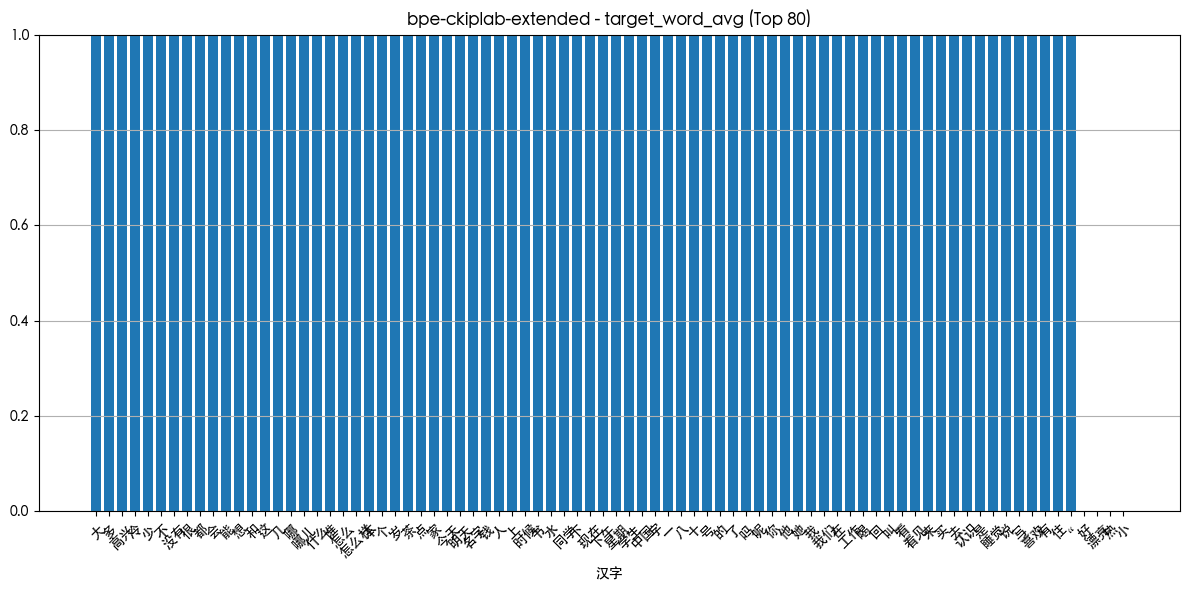

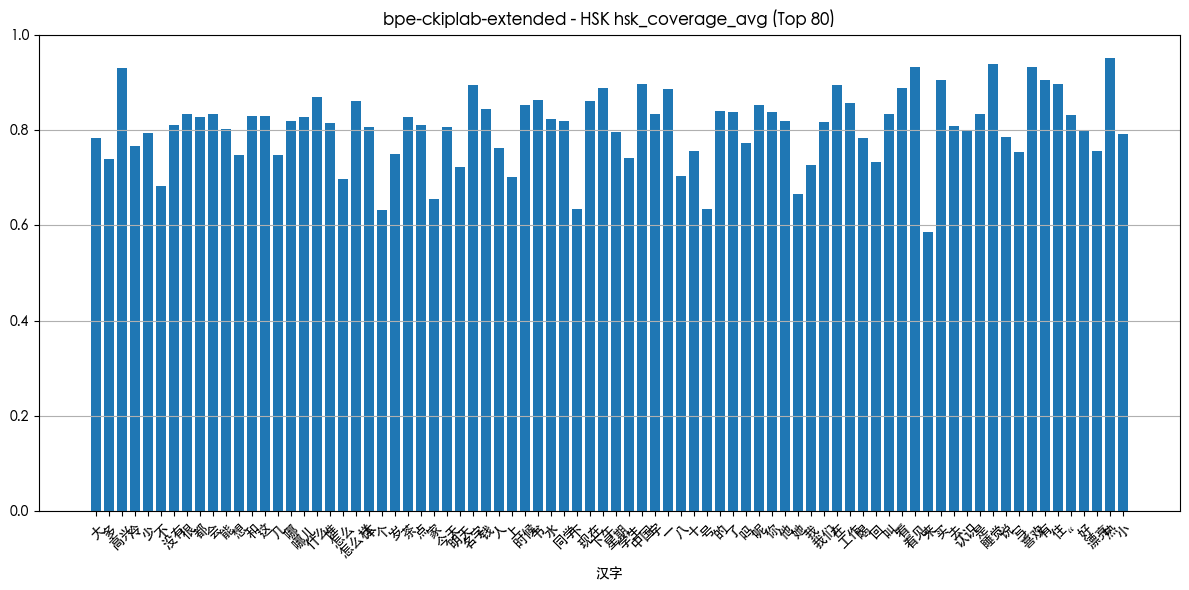

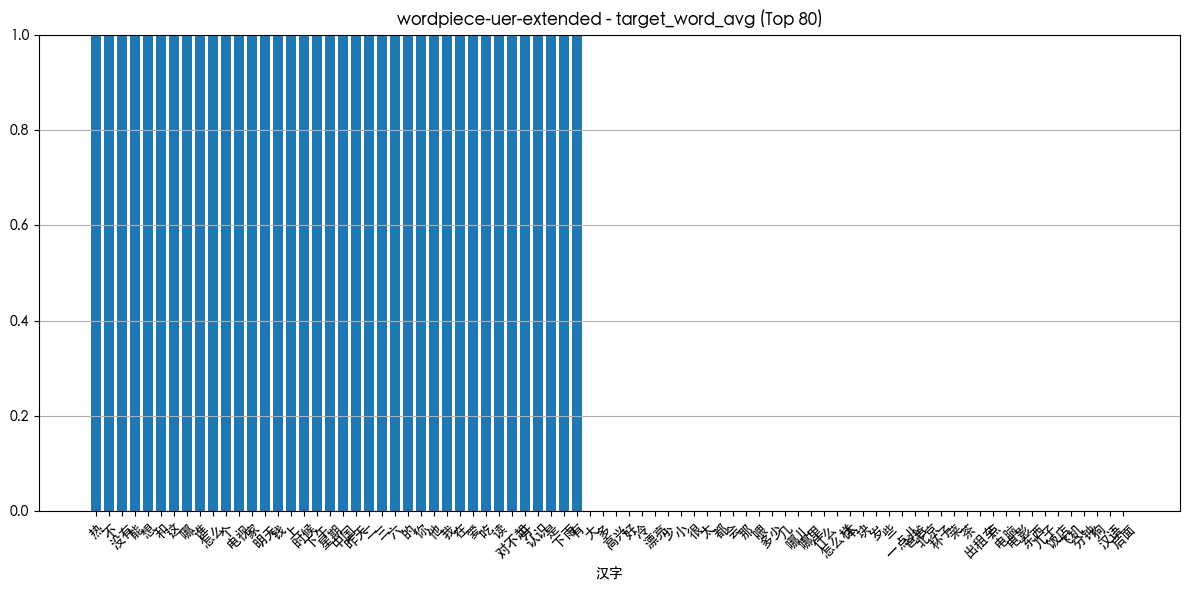

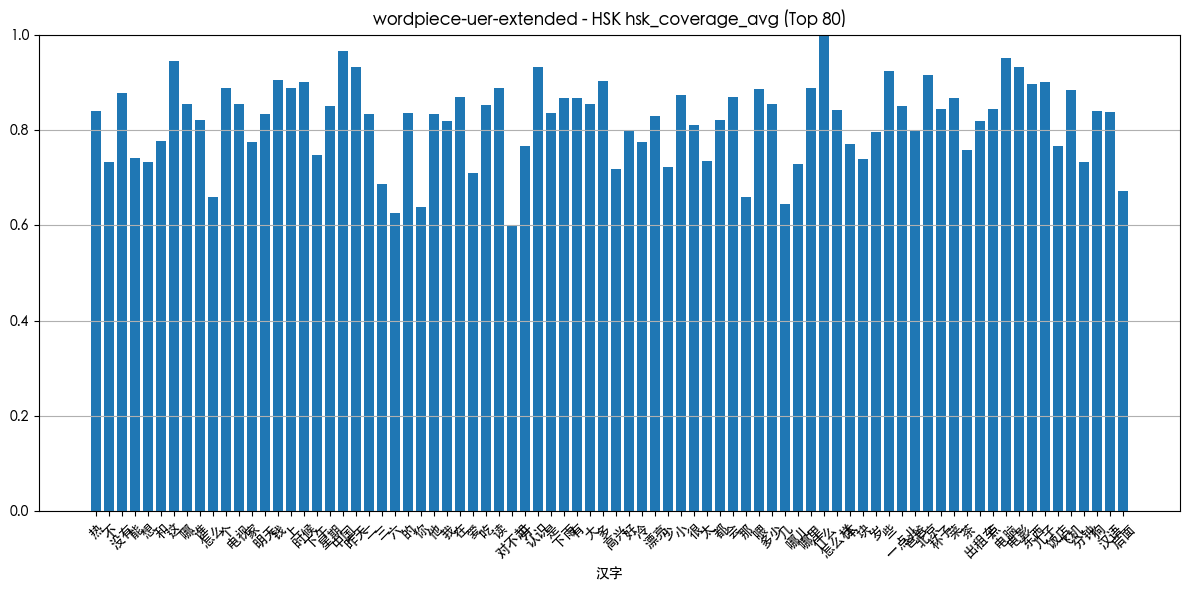

In [316]:
# models = [
#     {
#         "name": "bpe-ckiplab",
#         "path": "benchmarks/small_dataset/benchmark_0.json"
#     },
#     {
#         "name": "wordpiece-ckiplab",
#         "path": "benchmarks/small_dataset/benchmark_1.json"
#     },
#     {
#         "name": "bpe-uer",
#         "path": "benchmarks/small_dataset/benchmark_2.json"
#     },
#     {
#         "name": "wordpiece-uer",
#         "path": "benchmarks/small_dataset/benchmark_3.json"
#     }
# ]

models = [
    {
        "name": "bpe-ckiplab-extended",
        "path": "benchmarks/extended_dataset/benchmark_0.json"
    },
    {
        "name": "wordpiece-uer-extended",
        "path": "benchmarks/extended_dataset/benchmark_1.json"
    }
    
]

for model in models:
    results = json.load(open(model["path"], "r", encoding="utf-8"))
    plot_results(model["name"], results, top_n=80)

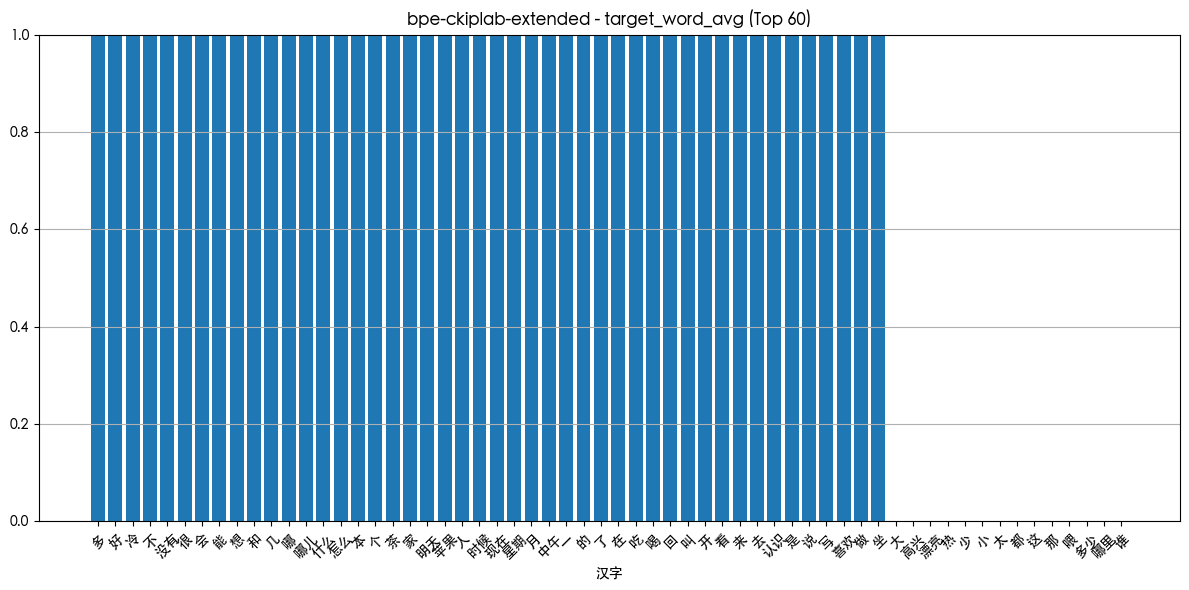

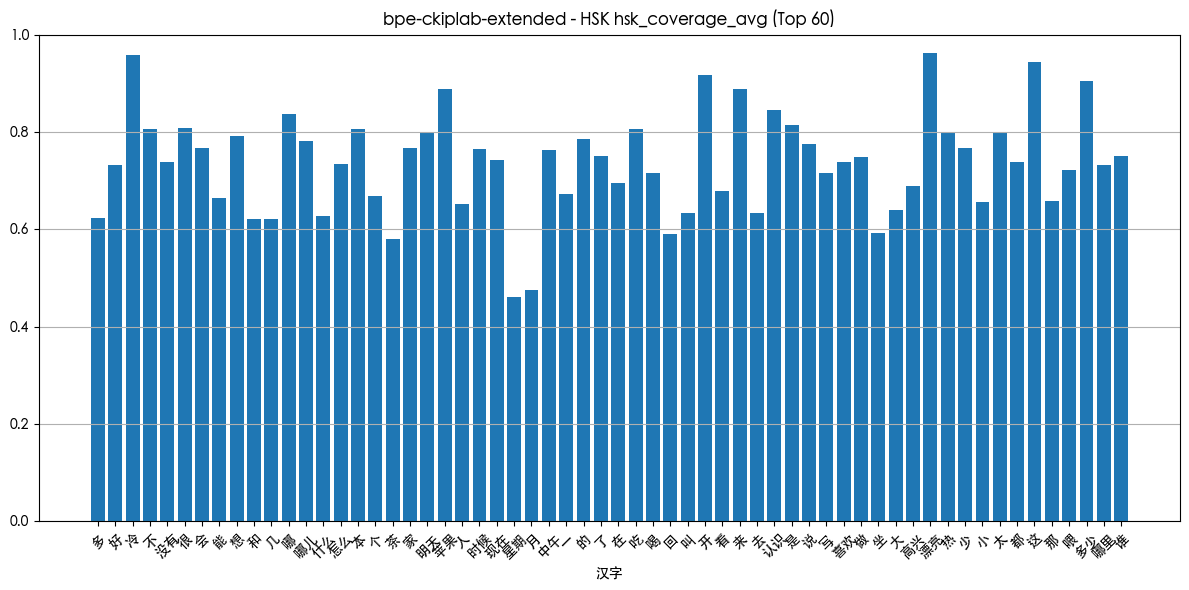

In [296]:
models = [
    {
        "name": "bpe-ckiplab-extended",
        "path": "benchmarks/benchmark_0.json"
    },
]

for model in models:
    results = json.load(open(model["path"], "r", encoding="utf-8"))
    plot_results(model["name"], results, top_n=60)